In [2]:
import os
%load_ext rpy2.ipython


In [3]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core'

nprocs = 20

In [4]:
%%R
library(ggplot2)
library(phyloseq)
library(tidyr)
library(plyr);library(dplyr)
library(scales)
library(biom)
library(metagenomeSeq)
library(doParallel)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

In [5]:
%%R

F = file.path(physeqDir, physeqBulk)

physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE) 
physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.Sparsity

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5877 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 5877 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 5877 tips and 5876 internal nodes ]


In [7]:
%%R
df.OM = read.csv('data/l2fc_sparse-maxRejH_bulk_OM.txt', sep = '\t')
head(df.OM)

  sparsity_threshold       OTU log2FoldChange     lfcSE      padj    Rank1
1               0.25  OTU.1739    -0.71456262 0.3329156 0.1470784 Bacteria
2               0.25  OTU.1813    -0.60046199 0.3295967 0.2408185 Bacteria
3               0.25   OTU.778     0.05599948 0.1374354 0.8514721 Bacteria
4               0.25  OTU.2180    -0.14337012 0.2565054 0.7822031 Bacteria
5               0.25 OTU.12365    -0.46298096 0.2428257 0.2130556 Bacteria
6               0.25  OTU.2343    -0.54901766 0.2810000 0.1990454 Bacteria
             Rank2          Rank3                  Rank4 Rank5 Rank6 Rank7
1 __Planctomycetes        __OM190 __uncultured_bacterium  <NA>  <NA>  <NA>
2 __Planctomycetes        __OM190 __uncultured_bacterium  <NA>  <NA>  <NA>
3 __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>  <NA>  <NA>
4 __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>  <NA>  <NA>
5 __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>  <NA>  <NA>
6 __Planctomycetes __Pla4

In [8]:
%%R
df.OM.r = filter(df.OM, padj2 <=0.10)
length(unique(df.OM.r$OTU))

[1] 245


In [9]:
%%R
physeq.Bulk.m = physeq.Bulk.r %>% sample_data

In [10]:
%%R
head(physeq.Bulk.m)

Sample Data:        [6 samples by 25 sample variables]:
                  Full.sample Fraction PrimerF PrimerR Barcode Rev.index
Nov.NTR.4.2015 Nov.NTR.4.2015       NA    515f    806r      84  gtctatga
S.NTR.2               S.NTR.2       NA    515f    806r     145  tagtctcc
June15.NTH.2     June15.NTH.2       NA    515f    806r      84  gtctatga
Oct.NTR.1.2015 Oct.NTR.1.2015       NA    515f    806r      46  ctgcgtag
July.NTR1           July.NTR1       NA    515f    806r     122  actcactg
July.NTR4           July.NTR4       NA    515f    806r     125  actcactg
               Fwd.index Treatment Day Replicate Pool Land_Management Gradient
Nov.NTR.4.2015  ctgcgtgt      <NA>  NA         4    8             NTR     <NA>
S.NTR.2         ctactata      <NA>  NA         2    5             NTR     <NA>
June15.NTH.2    ctgcgtgt      <NA>  NA         2    4             NTH     <NA>
Oct.NTR.1.2015  cgtgagtg      <NA>  NA         1    8             NTR     <NA>
July.NTR1       cgttacta      <NA>  NA

In [11]:
%%R
physeq.Bulk.m$Sample_Date = as.POSIXct(strptime(physeq.Bulk.m$Sample_Date, format = "%m/%d/%y"))
str(physeq.Bulk.m$Sample_Date)

 POSIXct[1:175], format: "2015-11-25" "2014-09-24" "2015-06-17" "2015-10-27" ...


In [12]:
%%R
physeq.Bulk.m$Day = round(difftime(physeq.Bulk.m$Sample_Date, min(physeq.Bulk.m$Sample_Date), 
         units = "days"))
tail(physeq.Bulk.m)

Sample Data:        [6 samples by 25 sample variables]:
                      Full.sample Fraction PrimerF PrimerR Barcode Rev.index
Sept.NTH.2.2015   Sept.NTH.2.2015       NA    515f    806r      28  actcactg
Oct.PTR.3.2015     Oct.PTR.3.2015       NA    515f    806r      55  tagtctcc
Aug.NTR.4.2015     Aug.NTR.4.2015       NA    515f    806r      19  acgctact
Aug.NTH.3.2015     Aug.NTH.3.2015       NA    515f    806r      11  gacatagt
April.NTR.3.2015 April.NTR.3.2015       NA    515f    806r      94  tatagcga
Nov.NTH.4.2015     Nov.NTH.4.2015       NA    515f    806r      81  gtctatga
                 Fwd.index Treatment      Day Replicate Pool Land_Management
Sept.NTH.2.2015   ctgcgtgt      <NA> 440 days         2    8             NTH
Oct.PTR.3.2015    ggatatct      <NA> 474 days         3    8             PTR
Aug.NTR.4.2015    tagcgagt      <NA> 399 days         4    8             NTR
Aug.NTH.3.2015    tagcgagt      <NA> 399 days         3    8             NTH
April.NTR.3.2015  cg

In [13]:
%%R
physeq.Bulk.m$Day_rel = as.numeric(physeq.Bulk.m$Day)


In [14]:
%%R
head(physeq.Bulk.m)

Sample Data:        [6 samples by 26 sample variables]:
                  Full.sample Fraction PrimerF PrimerR Barcode Rev.index
Nov.NTR.4.2015 Nov.NTR.4.2015       NA    515f    806r      84  gtctatga
S.NTR.2               S.NTR.2       NA    515f    806r     145  tagtctcc
June15.NTH.2     June15.NTH.2       NA    515f    806r      84  gtctatga
Oct.NTR.1.2015 Oct.NTR.1.2015       NA    515f    806r      46  ctgcgtag
July.NTR1           July.NTR1       NA    515f    806r     122  actcactg
July.NTR4           July.NTR4       NA    515f    806r     125  actcactg
               Fwd.index Treatment      Day Replicate Pool Land_Management
Nov.NTR.4.2015  ctgcgtgt      <NA> 503 days         4    8             NTR
S.NTR.2         ctactata      <NA>  76 days         2    5             NTR
June15.NTH.2    ctgcgtgt      <NA> 342 days         2    4             NTH
Oct.NTR.1.2015  cgtgagtg      <NA> 474 days         1    8             NTR
July.NTR1       cgttacta      <NA>   0 days         1    5

In [15]:
%%R
physeq.final = merge_phyloseq(physeq.Bulk.r, physeq.Bulk.m)
physeq.final

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5877 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 5877 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 5877 tips and 5876 internal nodes ]


In [16]:
%%R
ph.m = physeq.final %>% sample_data

head(ph.m)

Sample Data:        [6 samples by 26 sample variables]:
                  Full.sample Fraction PrimerF PrimerR Barcode Rev.index
Nov.NTR.4.2015 Nov.NTR.4.2015       NA    515f    806r      84  gtctatga
S.NTR.2               S.NTR.2       NA    515f    806r     145  tagtctcc
June15.NTH.2     June15.NTH.2       NA    515f    806r      84  gtctatga
Oct.NTR.1.2015 Oct.NTR.1.2015       NA    515f    806r      46  ctgcgtag
July.NTR1           July.NTR1       NA    515f    806r     122  actcactg
July.NTR4           July.NTR4       NA    515f    806r     125  actcactg
               Fwd.index Treatment Day Replicate Pool Land_Management Gradient
Nov.NTR.4.2015  ctgcgtgt      <NA>  NA         4    8             NTR     <NA>
S.NTR.2         ctactata      <NA>  NA         2    5             NTR     <NA>
June15.NTH.2    ctgcgtgt      <NA>  NA         2    4             NTH     <NA>
Oct.NTR.1.2015  cgtgagtg      <NA>  NA         1    8             NTR     <NA>
July.NTR1       cgttacta      <NA>  NA

In [17]:
%%R
make_metagenomeSeq = function(physeq) {
    require("metagenomeSeq")
    require("phyloseq")
    # Enforce orientation
    if (!taxa_are_rows(physeq)) {
        physeq <- t(physeq)
    }
    OTU = as(otu_table(physeq), "matrix")
    OTUOM = subset(OTU, rownames(OTU) %in% df.OM.r$OTU)

    # Convert sample_data to AnnotatedDataFrame
    ADF = AnnotatedDataFrame(data.frame(sample_data(physeq)))
    # define dummy 'feature' data for OTUs, using their name Helps with
    # extraction and relating to taxonomy later on.
    TDF = AnnotatedDataFrame(data.frame(tax_table(physeq)))
    TDFOM = subset(TDF, rownames(TDF) %in% df.OM.r$OTU)
    TDFOM$Rank9 = rownames(TDFOM)


    # Create the metagenomeSeq object
    MGS = newMRexperiment(counts = OTUOM, phenoData = ADF, featureData = TDFOM)
    # Trigger metagenomeSeq to calculate its Cumulative Sum scaling factor.
    MGS = cumNorm(MGS)
    return(MGS)
}

MR = make_metagenomeSeq(physeq.final)

In [18]:
%%R
str(MR)

Formal class 'MRexperiment' [package "metagenomeSeq"] with 8 slots
  ..@ expSummary       :<environment: 0x1198dae0> 
  ..@ assayData        :<environment: 0x11851cc8> 
  ..@ phenoData        :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  .. .. ..@ varMetadata      :'data.frame':	26 obs. of  1 variable:
  .. .. .. ..$ labelDescription: chr [1:26] NA NA NA NA ...
  .. .. ..@ data             :'data.frame':	175 obs. of  26 variables:
  .. .. .. ..$ Full.sample    : Factor w/ 175 levels "April15.NTH.1",..: 96 166 66 117 53 56 132 120 17 88 ...
  .. .. .. ..$ Fraction       : int [1:175] NA NA NA NA NA NA NA NA NA NA ...
  .. .. .. ..$ PrimerF        : Factor w/ 1 level "515f": 1 1 1 1 1 1 1 1 1 1 ...
  .. .. .. ..$ PrimerR        : Factor w/ 1 level "806r": 1 1 1 1 1 1 1 1 1 1 ...
  .. .. .. ..$ Barcode        : int [1:175] 84 145 84 46 122 125 159 62 2 181 ...
  .. .. .. ..$ Rev.index      : Factor w/ 12 levels "acgctact","actacgac",..: 8 10 8 6 3 3 5 5 4 8 ...
  .

In [19]:
%%R
TimeSeries = function(MR, feature) {  
    
    res = fitTimeSeries(obj = MR, lvl = 'Rank9', feature = feature, class = "OM",
                    id = "Full.sample", time = "Day_rel")

    return(res)
}




In [20]:
%%R
OTU = as(otu_table(physeq.final), "matrix")
OTUOM = subset(OTU, rownames(OTU) %in% df.OM.r$OTU)

feature = rownames(OTUOM)
str(feature)

 chr [1:245] "OTU.940" "OTU.5903" "OTU.11057" "OTU.1655" ...


In [21]:
%%R
#OTUs not found across all timepoints?
registerDoParallel(8)

TS = llply(feature, 
          TimeSeries, 
          .parallel = TRUE,
          MR = MR 
         )

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWa

In [22]:
%%R
str(TS)

List of 245
 $ :List of 5
  ..$ timeIntervals: num [1, 1:4] 106 418 -371 0
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
  ..$ data         :'data.frame':	175 obs. of  4 variables:
  .. ..$ abundance: num [1:175] 3.93 3.53 0 2.31 0 ...
  .. ..$ class    : Factor w/ 2 levels "H","R": 2 2 1 2 2 2 1 2 1 2 ...
  .. ..$ time     : num [1:175] 503 76 342 474 0 0 111 474 399 139 ...
  .. ..$ id       : Factor w/ 175 levels "April15.NTH.1",..: 96 166 66 117 53 56 132 120 17 88 ...
  ..$ fit          :'data.frame':	504 obs. of  3 variables:
  .. ..$ fit       : num [1:504] -0.0094 -0.0173 -0.0252 -0.0332 -0.0411 ...
  .. ..$ se        : num [1:504] 0.659 0.654 0.65 0.645 0.641 ...
  .. ..$ timePoints: num [1:504] 0 1 2 3 4 5 6 7 8 9 ...
  ..$ perm         : num [1:1000, 1] 18.61 10.78 -39.72 116.57 8.48 ...
  ..$ call         : language fitTimeSeries(obj = MR, feature = feature, class = "OM", time = "Day_rel", 

In [23]:
%%R
Make_DF = function(TS) {  
    
    d = data.frame(TS$data[, c("abundance","class", "time", "id")])
    d$Sample = rownames(TS$data)


    return(d)
}

In [24]:
%%R
l = list()
for (i in 1:length(feature)) {
    classname = as.vector(feature[i])
    l[[classname]] = Make_DF(TS[[i]])
    
}

In [25]:
%%R
DF = do.call(rbind, l)

In [26]:
%%R
DF$Class_Sample = rownames(DF)

In [27]:
%%R
head(DF)

                       abundance class time             id         Sample
OTU.940.Nov.NTR.4.2015  3.934112     R  503 Nov.NTR.4.2015 Nov.NTR.4.2015
OTU.940.S.NTR.2         3.533814     R   76        S.NTR.2        S.NTR.2
OTU.940.June15.NTH.2    0.000000     H  342   June15.NTH.2   June15.NTH.2
OTU.940.Oct.NTR.1.2015  2.308177     R  474 Oct.NTR.1.2015 Oct.NTR.1.2015
OTU.940.July.NTR1       0.000000     R    0      July.NTR1      July.NTR1
OTU.940.July.NTR4       2.285689     R    0      July.NTR4      July.NTR4
                                 Class_Sample
OTU.940.Nov.NTR.4.2015 OTU.940.Nov.NTR.4.2015
OTU.940.S.NTR.2               OTU.940.S.NTR.2
OTU.940.June15.NTH.2     OTU.940.June15.NTH.2
OTU.940.Oct.NTR.1.2015 OTU.940.Oct.NTR.1.2015
OTU.940.July.NTR1           OTU.940.July.NTR1
OTU.940.July.NTR4           OTU.940.July.NTR4


In [28]:
%%R
unique(DF$time)

 [1] 503  76 342 474   0 111 399 139 440 294 371


In [29]:
%%R
DF2 = separate(DF, Class_Sample, c('OTU', "num", "MY", "Treat", 'Rep'), sep = '\\.' )
DF2$C = paste(DF2$OTU, DF2$num, sep = '.')
DF2$Full.sample = paste(DF2$MY, DF2$Treat, DF2$Rep, sep = '.')
head(DF2)


                       abundance class time             id         Sample OTU
OTU.940.Nov.NTR.4.2015  3.934112     R  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU
OTU.940.S.NTR.2         3.533814     R   76        S.NTR.2        S.NTR.2 OTU
OTU.940.June15.NTH.2    0.000000     H  342   June15.NTH.2   June15.NTH.2 OTU
OTU.940.Oct.NTR.1.2015  2.308177     R  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU
OTU.940.July.NTR1       0.000000     R    0      July.NTR1      July.NTR1 OTU
OTU.940.July.NTR4       2.285689     R    0      July.NTR4      July.NTR4 OTU
                       num     MY Treat  Rep       C  Full.sample
OTU.940.Nov.NTR.4.2015 940    Nov   NTR    4 OTU.940    Nov.NTR.4
OTU.940.S.NTR.2        940      S   NTR    2 OTU.940      S.NTR.2
OTU.940.June15.NTH.2   940 June15   NTH    2 OTU.940 June15.NTH.2
OTU.940.Oct.NTR.1.2015 940    Oct   NTR    1 OTU.940    Oct.NTR.1
OTU.940.July.NTR1      940   July  NTR1 <NA> OTU.940 July.NTR1.NA
OTU.940.July.NTR4      940   July  NTR4 <NA> OTU.940 July.

In [30]:
%%R
length(unique(DF2$Rep))

[1] 5


In [31]:
%%R
Make_DF2 = function(TS) {  
    
    d = data.frame(TS$timeIntervals)


    return(d)
}

In [32]:
%%R
l.pval = list()
for (i in 1:length(feature)) {
    classname = as.character(feature[i])
    l.pval[[classname]] = Make_DF2(TS[[i]])
    
}

In [33]:
%%R
l.pval2 = list()


for (i in 1:length(l.pval)) {
        if (length(l.pval[[i]]) == 1) {
        l.pval2[[i]] = l.pval[[i]]
        l.pval2[[i]]$Interval.start = NA
        l.pval2[[i]]$Interval.end = NA
        l.pval2[[i]]$Area = NA
        l.pval2[[i]]$p.value = NA
        l.pval2[[i]]$TS.timeIntervals = NULL
    } else {
            l.pval2[[i]] = l.pval[[i]]
        } 
    
}

In [34]:
%%R

l.pval3 = list()
for (i in 1:length(feature)) {
    classname = as.character(feature[i])
    l.pval3[[classname]] = l.pval2[[i]]
    
}

In [35]:
%%R
DF3 = do.call(rbind, l.pval3)

In [36]:
%%R
DF3$C = rownames(DF3)
head(DF3)


           Interval.start Interval.end      Area p.value          C
OTU.940               106          418 -371.0229   0.000    OTU.940
OTU.5903                0          503  542.5379   0.000   OTU.5903
OTU.11057               0          482 -479.0979   0.000  OTU.11057
OTU.1655.1              0          142 -161.2317   0.013 OTU.1655.1
OTU.1655.2            373          503 -125.0276   0.002 OTU.1655.2
OTU.3534              107          503  412.2352   0.001   OTU.3534


In [37]:
%%R
head(DF2)
df.total = left_join(DF2, DF3)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: "C"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [38]:
%%R
head(df.total)

  abundance class time             id         Sample OTU num     MY Treat  Rep
1  3.934112     R  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 940    Nov   NTR    4
2  3.533814     R   76        S.NTR.2        S.NTR.2 OTU 940      S   NTR    2
3  0.000000     H  342   June15.NTH.2   June15.NTH.2 OTU 940 June15   NTH    2
4  2.308177     R  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 940    Oct   NTR    1
5  0.000000     R    0      July.NTR1      July.NTR1 OTU 940   July  NTR1 <NA>
6  2.285689     R    0      July.NTR4      July.NTR4 OTU 940   July  NTR4 <NA>
        C  Full.sample Interval.start Interval.end      Area p.value
1 OTU.940    Nov.NTR.4            106          418 -371.0229       0
2 OTU.940      S.NTR.2            106          418 -371.0229       0
3 OTU.940 June15.NTH.2            106          418 -371.0229       0
4 OTU.940    Oct.NTR.1            106          418 -371.0229       0
5 OTU.940 July.NTR1.NA            106          418 -371.0229       0
6 OTU.940 July.NTR4.NA           

In [39]:
%%R
length(unique(df.total$C))

[1] 245


In [40]:
%%R
Make_DF3 = function(TS) {  
    
    d = data.frame(TS$fit[, c("fit","se", "timePoints")])
    d$Sample = rownames(TS$fit)


    return(d)
}

In [41]:
%%R

l2 = list()
for (i in 1:length(feature)) {
    classname = as.vector(feature[i])
    l2[[classname]] = Make_DF3(TS[[i]])
    
}

In [42]:
%%R
fit = do.call(rbind, l2)

In [43]:
%%R
head(fit)

                   fit        se timePoints Sample
OTU.940.1 -0.009400632 0.6588909          0      1
OTU.940.2 -0.017322520 0.6542666          1      2
OTU.940.3 -0.025248809 0.6496819          2      3
OTU.940.4 -0.033179163 0.6451370          3      4
OTU.940.5 -0.041113248 0.6406319          4      5
OTU.940.6 -0.049050731 0.6361669          5      6


In [44]:
%%R
require(tidyr)
fit$C = rownames(fit)
fit$time = fit$timePoints
fit$timePoints = NULL

In [45]:
%%R
fit2 = fit %>% separate(C, c("OTU", 'num', 'extra'), sep = '\\.')
fit2$C = paste(fit2$OTU, fit2$num, sep ='.')
fit2$OTU = NULL
fit2$num = NULL
fit2$extra = NULL
head(fit2)

                   fit        se Sample time       C
OTU.940.1 -0.009400632 0.6588909      1    0 OTU.940
OTU.940.2 -0.017322520 0.6542666      2    1 OTU.940
OTU.940.3 -0.025248809 0.6496819      3    2 OTU.940
OTU.940.4 -0.033179163 0.6451370      4    3 OTU.940
OTU.940.5 -0.041113248 0.6406319      5    4 OTU.940
OTU.940.6 -0.049050731 0.6361669      6    5 OTU.940


In [46]:
%%R
df.all = left_join(df.total, fit2, by = c('time', 'C'))

In [47]:
%%R
head(df.all)

  abundance class time             id       Sample.x OTU num     MY Treat  Rep
1  3.934112     R  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 940    Nov   NTR    4
2  3.533814     R   76        S.NTR.2        S.NTR.2 OTU 940      S   NTR    2
3  0.000000     H  342   June15.NTH.2   June15.NTH.2 OTU 940 June15   NTH    2
4  2.308177     R  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 940    Oct   NTR    1
5  0.000000     R    0      July.NTR1      July.NTR1 OTU 940   July  NTR1 <NA>
6  2.285689     R    0      July.NTR4      July.NTR4 OTU 940   July  NTR4 <NA>
        C  Full.sample Interval.start Interval.end      Area p.value
1 OTU.940    Nov.NTR.4            106          418 -371.0229       0
2 OTU.940      S.NTR.2            106          418 -371.0229       0
3 OTU.940 June15.NTH.2            106          418 -371.0229       0
4 OTU.940    Oct.NTR.1            106          418 -371.0229       0
5 OTU.940 July.NTR1.NA            106          418 -371.0229       0
6 OTU.940 July.NTR4.NA           

In [48]:
%%R
unique(df.all$Interval.end)

 [1] 418 503 482  NA 287 426 388 444 408 484 355 501 434 473 429 475 353 453 366
[20] 472 454 356 458 498 389 452 317 425 275 400 435 413 343 318 401 479 499 436
[39] 417 271 466 249 350 283 219 302 409 376 336 442 395 456 396 380 377 445 382
[58] 369 451 206 465 411 370 325 410 478 483 455 469 439 359 428 419 371 292 474
[77] 402 403 272 280 476 467 438 463 437


In [49]:
%%R
df.sig = filter(df.all, p.value <=0.01)

In [50]:
%%R
write.csv(df.sig, file = "data/OM_TS.csv",row.names=FALSE)

In [51]:
%%R
df.sig = read.csv('data/OM_TS.csv')

In [52]:
%%R
length(unique(df.sig$C))

[1] 212


In [53]:
%%R
df.sig %>% group_by(C) %>% summarise(IS = mean(Interval.start), IE = mean(Interval.end))

Source: local data frame [212 x 3]

           C    IS    IE
      (fctr) (dbl) (dbl)
1    OTU.102    19   503
2   OTU.1026    30   503
3   OTU.1031    39   482
4   OTU.1035     0   482
5  OTU.10376     0   503
6   OTU.1069    49   478
7   OTU.1098     0   445
8  OTU.11057     0   482
9   OTU.1118     0   389
10  OTU.1136   131   503
..       ...   ...   ...


In [54]:
%%R
print(unique(df.sig$time))
print(unique(df.sig$Interval.start))
print(unique(df.sig$Interval.end))

 [1] 503  76 342 474   0 111 399 139 440 294 371
 [1] 106   0 107  89  40 187 127 171 145  62 186  17 190  57 100  52 105   1 211
[20]  90  99  61  10 109  30   3 193 118   4 117   5  50 119  92  41  32  84  19
[39]  26  88 183  39   2 102 121 131 201  73  82  74 202  67  58 144 135  33  91
[58] 133  51 161  49  13 241  27  78 170 240 110 138  55  22
 [1] 418 503 482 287 426 388 444 408 484 501 473 429 475 353 453 366 472 454 356
[20] 458 498 389 452 425 400 435 413 343 318 401 479 499 436 271 249 302 409 376
[39] 336 442 395 456 396 380 377 445 451 206 465 410 478 483 455 469 439 359 428
[58] 419 371 474 402 272 476 467 438 463 437


%%R


df.sig$T[df.sig$time == 0] = '2014-7-10'
df.sig$T[df.sig$time == 2] = '2014-9-24'
df.sig$T[df.sig$time == 3] = '2014-10-29'
df.sig$T[df.sig$time == 4] = '2014-11-26'
df.sig$T[df.sig$time == 9] = '2015-4-30'
df.sig$T[df.sig$time == 11] = '2015-6-17'
df.sig$T[df.sig$time == 12] = '2015-7-16'
df.sig$T[df.sig$time == 13] = '2015-8-13'
df.sig$T[df.sig$time == 14] = '2015-9-23'
df.sig$T[df.sig$time == 15] = '2015-10-27'
df.sig$T[df.sig$time == 16] = '2015-11-25'

df.sig$T = as.POSIXct(strptime(df.sig$T, format = "%Y-%m-%d"))


df.sig$Interval.start[df.sig$Interval.start == 0] = '2014-7-10'
df.sig$Interval.start[df.sig$Interval.start == 2] = '2014-9-24'
df.sig$Interval.start[df.sig$Interval.start == 3] = '2014-10-29'
df.sig$Interval.start[df.sig$Interval.start == 4] = '2014-11-26'
df.sig$Interval.start[df.sig$Interval.start == 9] = '2015-4-30'
df.sig$Interval.start[df.sig$Interval.start == 11] = '2015-6-17'
df.sig$Interval.start[df.sig$Interval.start == 12] = '2015-7-16'
df.sig$Interval.start[df.sig$Interval.start == 13] = '2015-8-13'
df.sig$Interval.start[df.sig$Interval.start== 14] = '2015-9-23'
df.sig$Interval.start[df.sig$Interval.start == 15] = '2015-10-27'
df.sig$Interval.start[df.sig$Interval.start == 16] = '2015-11-25'

df.sig$Interval.start = as.POSIXct(strptime(df.sig$Interval.start, format = "%Y-%m-%d"))

df.sig$Interval.end[df.sig$Interval.end == 0] = '2014-7-10'
df.sig$Interval.end[df.sig$Interval.end == 2] = '2014-9-24'
df.sig$Interval.end[df.sig$Interval.end == 3] = '2014-10-29'
df.sig$Interval.end[df.sig$Interval.end == 4] = '2014-11-26'
df.sig$Interval.end[df.sig$Interval.end == 9] = '2015-4-30'
df.sig$Interval.end[df.sig$Interval.end == 11] = '2015-6-17'
df.sig$Interval.end[df.sig$Interval.end == 12] = '2015-7-16'
df.sig$Interval.end[df.sig$Interval.end == 13] = '2015-8-13'
 df.sig$Interval.end[df.sig$Interval.end == 14] = '2015-9-23'
df.sig$Interval.end[df.sig$Interval.end == 15] = '2015-10-27'
df.sig$Interval.end[df.sig$Interval.end == 16] = '2015-11-25'
# 
df.sig$Interval.end = as.POSIXct(strptime(df.sig$Interval.end, format = "%Y-%m-%d"))


head(df.sig)

In [55]:
%%R
length(unique(df.sig$C))

[1] 212


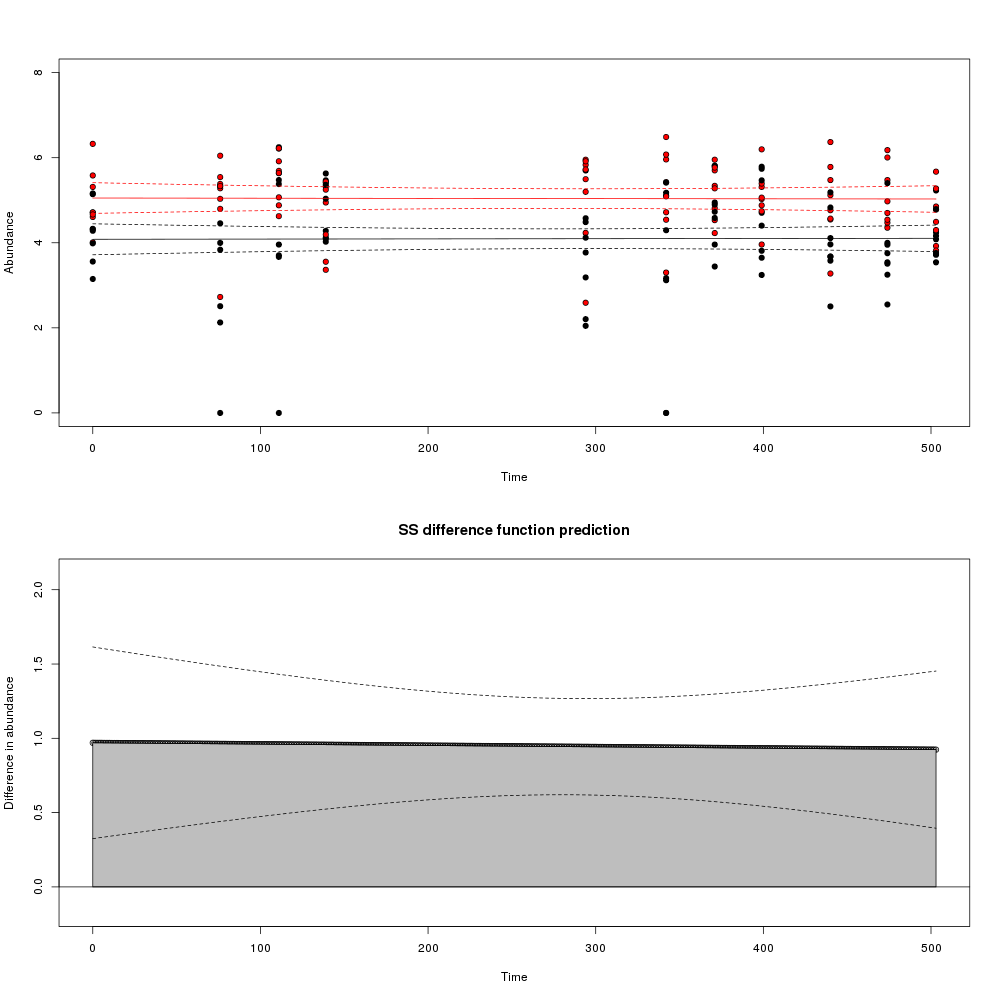

In [56]:
%%R -h 1000 -w 1000
Phy = TS[[60]]
par(mfrow = c(2, 1))
plotClassTimeSeries(Phy, pch = 21, bg = Phy$data$class, ylim = c(0,8))
plotTimeSeries(Phy)

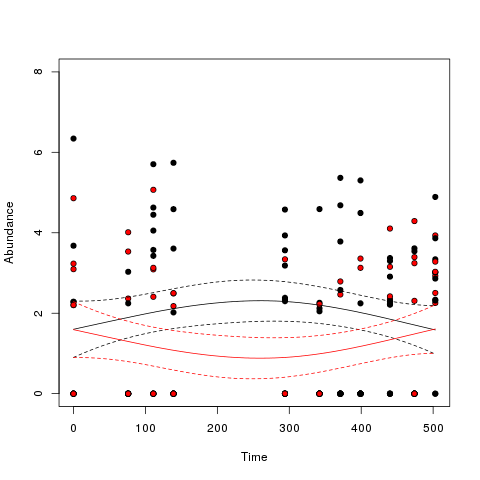

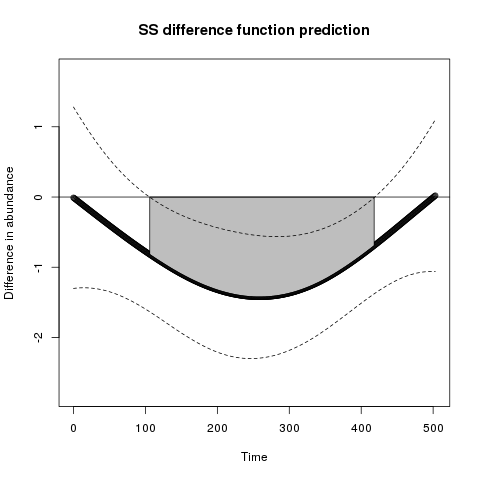

In [57]:
%%R
plotClassTimeSeries(TS[[1]], pch = 21, bg = Phy$data$class, ylim = c(0,8))
plotTimeSeries(TS[[1]])

In [58]:
%%R
plotClassTimeSeries.df <-function(df, formula, v, xlab="Time",ylab="Abundance",color0="black",
                            color1="red",include=c("1","class", "time:class"),...){
    if(missing(formula)){
        mod = gss::ssanova(abundance ~ time * class, data=df)
    } else{
        mod = gss::ssanova(formula,data=df)
    }
    
    timePoints = seq(min(df$time),max(df$time),by=1)
    group0 = data.frame(time=timePoints,class=levels(df$class)[1])
    group1 = data.frame(time=timePoints,class=levels(df$class)[2])
    pred0  = predict(mod, newdata=group0,include=include, se=TRUE)
    pred1  = predict(mod, newdata=group1,include=include, se=TRUE)
    
    
    plot(x=df$time,y=df$abundance,xlab=xlab,ylab=ylab,...)
    lines(x=group0$time,y=pred0$fit,col=color0)
    lines(x=group0$time,y=pred0$fit+(1.96*pred0$se),lty=2,col=color0)
    lines(x=group0$time,y=pred0$fit-(1.96*pred0$se),lty=2,col=color0)

    lines(x=group1$time,y=pred1$fit,col=color1)
    lines(x=group1$time,y=pred1$fit+(1.96*pred1$se),lty=2,col=color1)
    lines(x=group1$time,y=pred1$fit-(1.96*pred1$se),lty=2,col=color1)
    
    title(main = v)
    
   #text(bquote(paste(.(unique(df$p.value)))))
}

In [59]:
%%R
head(df.sig)

  abundance class time             id       Sample.x OTU num     MY Treat Rep
1  3.934112     R  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 940    Nov   NTR   4
2  3.533814     R   76        S.NTR.2        S.NTR.2 OTU 940      S   NTR   2
3  0.000000     H  342   June15.NTH.2   June15.NTH.2 OTU 940 June15   NTH   2
4  2.308177     R  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 940    Oct   NTR   1
5  0.000000     R    0      July.NTR1      July.NTR1 OTU 940   July  NTR1  NA
6  2.285689     R    0      July.NTR4      July.NTR4 OTU 940   July  NTR4  NA
        C  Full.sample Interval.start Interval.end      Area p.value
1 OTU.940    Nov.NTR.4            106          418 -371.0229       0
2 OTU.940      S.NTR.2            106          418 -371.0229       0
3 OTU.940 June15.NTH.2            106          418 -371.0229       0
4 OTU.940    Oct.NTR.1            106          418 -371.0229       0
5 OTU.940 July.NTR1.NA            106          418 -371.0229       0
6 OTU.940 July.NTR4.NA            106   

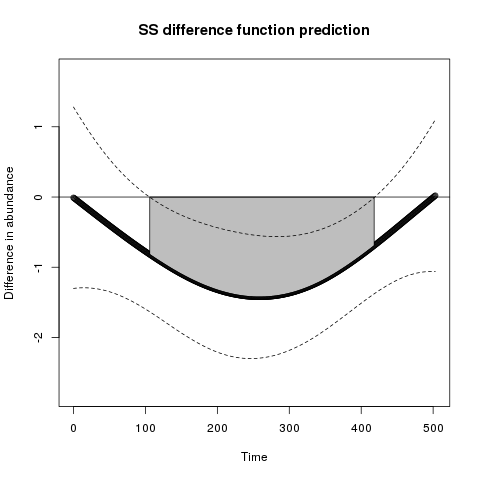

In [60]:
%%R
plotTimeSeries(TS[[1]])

In [61]:
%%R
plotTimeSeries.df <-function(df,C=0,xlab="Time",ylab="Difference in abundance",main="SS difference function prediction",...){
    
    fit = df$fit
    se  = df$se
    timePoints = res$fit$timePoints
    confInt95 = 1.96
    sigDiff = res$timeIntervals

    minValue=min(fit-(confInt95*se))-.5
    maxValue=max(fit+(confInt95*se))+.5

    plot(x=timePoints, y=fit, ylim=c(minValue, maxValue), xlab=xlab, ylab=ylab, main=main, ...)

    for (i in 1:nrow(sigDiff)){
        begin=sigDiff[i,1]
        end=sigDiff[i,2]
        indBegin=which(timePoints==begin)
        indEnd=which(timePoints==end)
        x=timePoints[indBegin:indEnd]
        y=fit[indBegin:indEnd]
        xx=c(x, rev(x))
        yy=c(y, rep(0, length(y)))
        polygon(x=xx, yy, col="grey")
    }
    lines(x=timePoints, y=fit, pch="")
    lines(x=timePoints, y=fit+(confInt95*se), pch="", lty=2)
    lines(x=timePoints, y=fit-(confInt95*se), pch="", lty=2)
    abline(h=C)
}

In [64]:
%%R
lc = list()
for (C in clist){
        d = filter(df.sig, C == C)
        lc[[C]] = d
    }

test = head(lc)


Error in withVisible({ : object 'clist' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'clist' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [65]:
%%R
registerDoParallel(8)

lapply(lc, plotClassTimeSeries.df, .parallel = TRUE)

list()


In [66]:
%%R -h 2000 -w 1200

do.call("grid.arrange", c(plots.l, nrow=length(names(plots.l))))


Error in do.call("grid.arrange", c(plots.l, nrow = length(names(plots.l)))) : 
  error in evaluating the argument 'args' in selecting a method for function 'do.call': Error: object 'plots.l' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in do.call("grid.arrange", c(plots.l, nrow = length(names(plots.l)))) : 
  error in evaluating the argument 'args' in selecting a method for function 'do.call': Error: object 'plots.l' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [67]:
%%R
head(df.sig)

  abundance class time             id       Sample.x OTU num     MY Treat Rep
1  3.934112     R  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 940    Nov   NTR   4
2  3.533814     R   76        S.NTR.2        S.NTR.2 OTU 940      S   NTR   2
3  0.000000     H  342   June15.NTH.2   June15.NTH.2 OTU 940 June15   NTH   2
4  2.308177     R  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 940    Oct   NTR   1
5  0.000000     R    0      July.NTR1      July.NTR1 OTU 940   July  NTR1  NA
6  2.285689     R    0      July.NTR4      July.NTR4 OTU 940   July  NTR4  NA
        C  Full.sample Interval.start Interval.end      Area p.value
1 OTU.940    Nov.NTR.4            106          418 -371.0229       0
2 OTU.940      S.NTR.2            106          418 -371.0229       0
3 OTU.940 June15.NTH.2            106          418 -371.0229       0
4 OTU.940    Oct.NTR.1            106          418 -371.0229       0
5 OTU.940 July.NTR1.NA            106          418 -371.0229       0
6 OTU.940 July.NTR4.NA            106   

In [68]:
%%R
head(df.sig) %>% as.data.frame

  abundance class time             id       Sample.x OTU num     MY Treat Rep
1  3.934112     R  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 940    Nov   NTR   4
2  3.533814     R   76        S.NTR.2        S.NTR.2 OTU 940      S   NTR   2
3  0.000000     H  342   June15.NTH.2   June15.NTH.2 OTU 940 June15   NTH   2
4  2.308177     R  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 940    Oct   NTR   1
5  0.000000     R    0      July.NTR1      July.NTR1 OTU 940   July  NTR1  NA
6  2.285689     R    0      July.NTR4      July.NTR4 OTU 940   July  NTR4  NA
        C  Full.sample Interval.start Interval.end      Area p.value
1 OTU.940    Nov.NTR.4            106          418 -371.0229       0
2 OTU.940      S.NTR.2            106          418 -371.0229       0
3 OTU.940 June15.NTH.2            106          418 -371.0229       0
4 OTU.940    Oct.NTR.1            106          418 -371.0229       0
5 OTU.940 July.NTR1.NA            106          418 -371.0229       0
6 OTU.940 July.NTR4.NA            106   

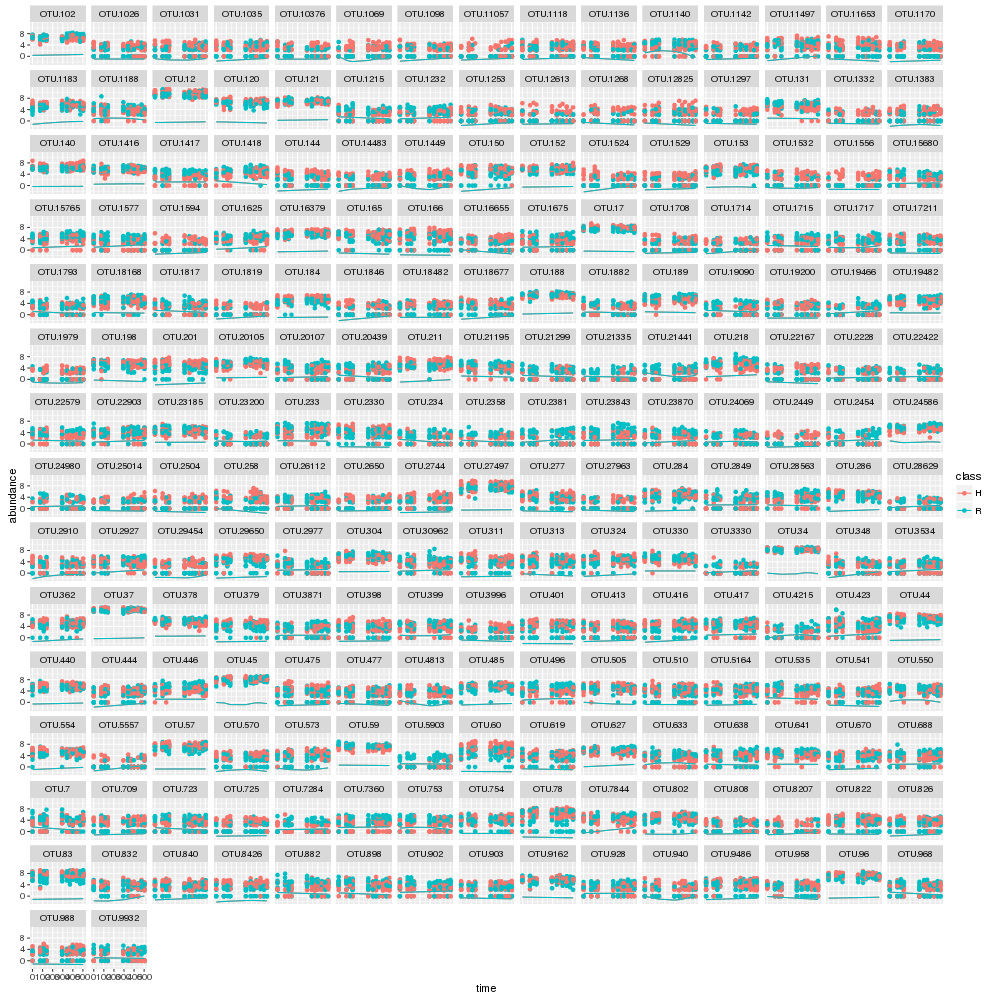

In [69]:
%%R -h 1000 -w 1000
head(df.sig)

ggplot(df.sig, aes(x = time, y = abundance, color = class)) + 
geom_point() + 
geom_line(aes(x = time, y = fit, color = class, group = class)) +
facet_wrap(~C)

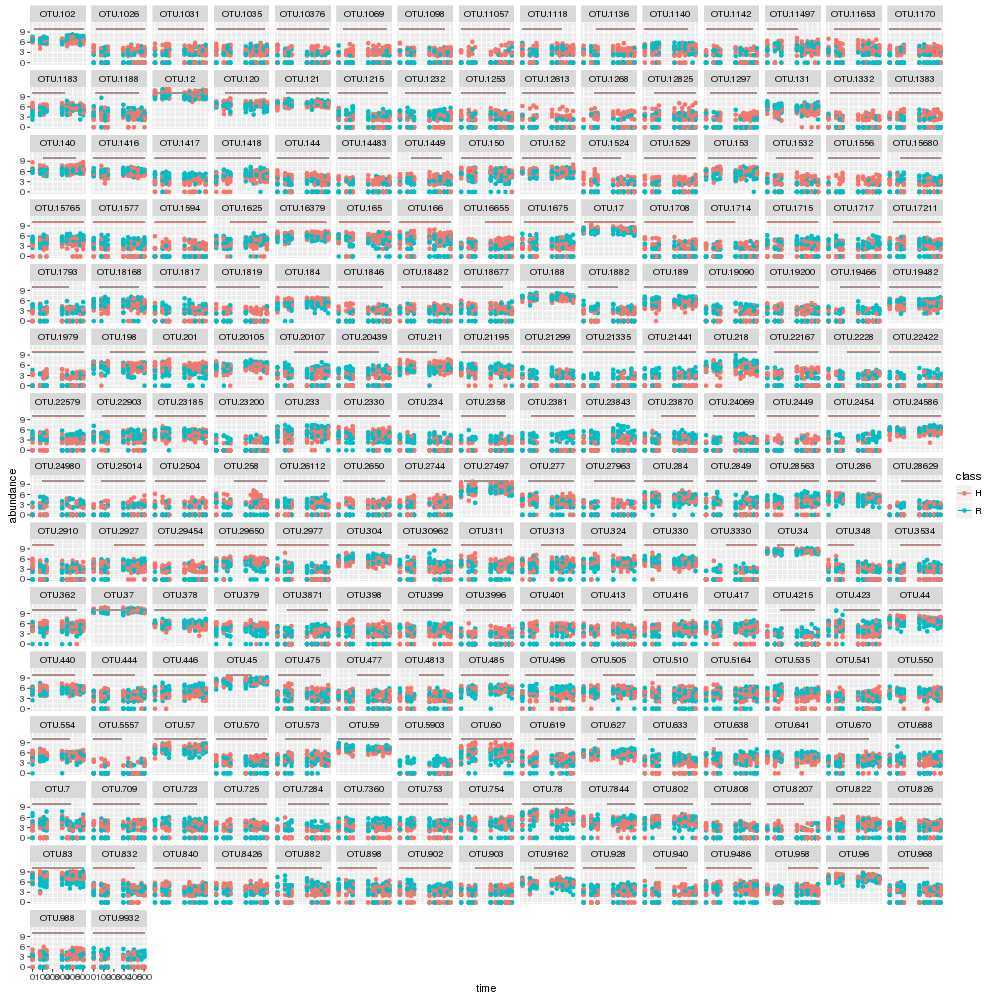

In [70]:
%%R -h 1000 -w 1000
head(df.sig)

ggplot(df.sig, aes(x = time, y = abundance, color = class)) + 
geom_point() + 
geom_segment(aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) +
facet_wrap(~C)

In [71]:
%%R
df.sum = df.sig %>% group_by(C, time, class) %>% summarise(meanab = mean(abundance), sdab = sd(abundance))
head(df.sum)

Source: local data frame [6 x 5]
Groups: C, time [3]

        C  time  class   meanab      sdab
   (fctr) (int) (fctr)    (dbl)     (dbl)
1 OTU.102     0      H 6.566491 0.4479094
2 OTU.102     0      R 7.050025 0.4799858
3 OTU.102    76      H 6.020156 1.0173165
4 OTU.102    76      R 6.482400 0.5797879
5 OTU.102   111      H 6.519676 0.5866708
6 OTU.102   111      R 6.906415 0.6009012


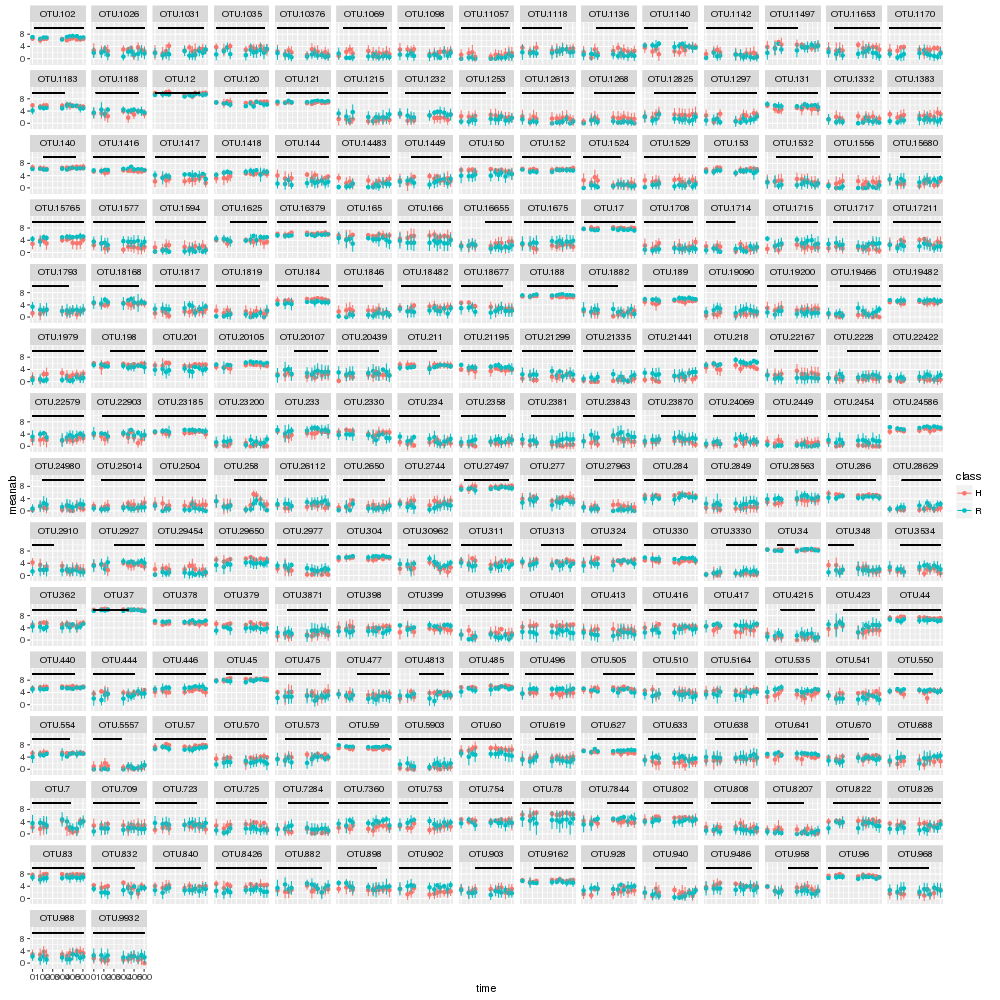

In [72]:
%%R -h 1000 -w 1000
limits = aes(ymax = meanab + sdab, ymin=meanab -sdab, color = class)


ggplot(df.sum, aes(x = time, y = meanab)) + 
geom_point(aes(color = class)) + 
geom_errorbar(limits, width=0.25)+
geom_segment(data = df.sig, aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) +
facet_wrap(~C)

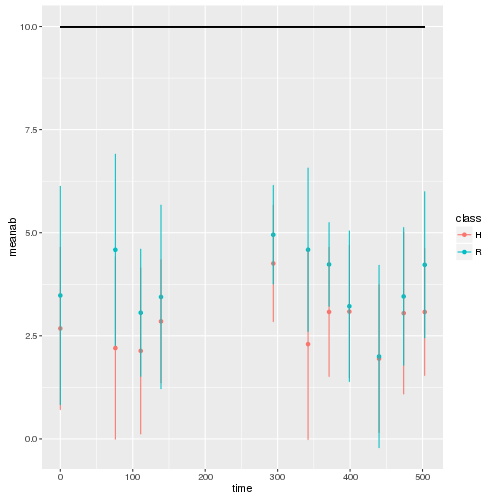

In [79]:
%%R -h 500 -w 500

test = filter(df.sum, C == 'OTU.882')
limits = aes(ymax = meanab + sdab, ymin=meanab -sdab, color = class)


ggplot(test, aes(x = time, y = meanab)) + 
geom_point(aes(color = class)) + 
geom_errorbar(limits, width=0.25)+
geom_segment(data = df.sig, aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) #+
#facet_wrap(~C)

In [73]:
%%R
head(df.sig)

  abundance class time             id       Sample.x OTU num     MY Treat Rep
1  3.934112     R  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 940    Nov   NTR   4
2  3.533814     R   76        S.NTR.2        S.NTR.2 OTU 940      S   NTR   2
3  0.000000     H  342   June15.NTH.2   June15.NTH.2 OTU 940 June15   NTH   2
4  2.308177     R  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 940    Oct   NTR   1
5  0.000000     R    0      July.NTR1      July.NTR1 OTU 940   July  NTR1  NA
6  2.285689     R    0      July.NTR4      July.NTR4 OTU 940   July  NTR4  NA
        C  Full.sample Interval.start Interval.end      Area p.value
1 OTU.940    Nov.NTR.4            106          418 -371.0229       0
2 OTU.940      S.NTR.2            106          418 -371.0229       0
3 OTU.940 June15.NTH.2            106          418 -371.0229       0
4 OTU.940    Oct.NTR.1            106          418 -371.0229       0
5 OTU.940 July.NTR1.NA            106          418 -371.0229       0
6 OTU.940 July.NTR4.NA            106   

In [74]:
%%R
sessionInfo()

R version 3.2.3 (2015-12-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu precise (12.04.5 LTS)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] doParallel_1.0.10     iterators_1.0.8       metagenomeSeq_1.11.10
 [4] RColorBrewer_1.1-2    glmnet_2.0-3          foreach_1.4.3        
 [7] Matrix_1.2-3          limma_3.22.7          Biobase_2.26.0       
[10] BiocGenerics_0.12.1   biom_0.3.12           scales_0.3.0         
[13] dplyr_0.4.3           plyr_1.8.3            tidyr_0.4.1          
[16] phyloseq_1.10.0 